# Object Tracking 

In **object tracking**, we try to track the motion of objects in a sequence of frames, i.e., a video (Yilmaz et al., 2006). In order to track objects, we first need to detect and identify them.

This notebook shows how to track objects in a video.<br> 
The video is at first devided into single frames and in each frame a pre-trained ``PyTorch`` model detects the objects. Finally, the inferenced frames are streamed as video.

The code in this notebook is from this github repository: [cfotache_pytorch_objectdetecttrack](https://github.com/cfotache/pytorch_objectdetecttrack.git)

## Preparation

- Clone github data
- Install additional module 'filterpy'
- Download YOLOv3 weights
- Download sample video
- Append paths

In [ ]:
!pip install filterpy

In [ ]:
# Clone repository 
!git clone https://github.com/cfotache/pytorch_objectdetecttrack.git

Cloning into 'pytorch_objectdetecttrack'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.


In [ ]:
os.chdir('/content/pytorch_objectdetecttrack/')

In [ ]:
# Download YOLOv3 weights

import subprocess

os.chmod('/content/pytorch_objectdetecttrack/config/download_weights.sh', 777)

subprocess.call(["/content/pytorch_objectdetecttrack/config/download_weights.sh"])

0

In [ ]:
# Add paths from repository structure to use additional modules

import sys
sys.path.append('/content/pytorch_objectdetecttrack/')

In [ ]:
# Download sample video

videopath = '/content/pytorch_objectdetecttrack/overpass.mp4'

!curl -o $videopath  https://raw.githubusercontent.com/iubh/DLMAINLPCV01/master/data/cv_videos/Pexels%20Videos%202880.mp4

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7933k  100 7933k    0     0  22.1M      0 --:--:-- --:--:-- --:--:-- 22.2M


## Setup

In [ ]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [ ]:
config_path='config/yolov3.cfg'
weights_path='/content/pytorch_objectdetecttrack/yolov3.weights'
class_path='config/coco.names'
img_size=416
conf_thres=0.8
nms_thres=0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


## Object detection

In [ ]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

# Object tracking

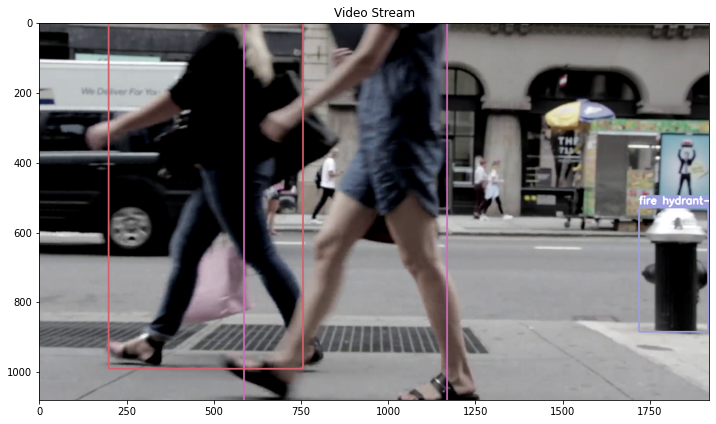

In [ ]:
%pylab inline 
import cv2
from IPython.display import clear_output

cmap = plt.get_cmap('tab20b')
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]

# initialize Sort object and video capture
from sort import *
vid = cv2.VideoCapture(videopath)
mot_tracker = Sort() 

#while(True):
for ii in range(400):
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        tracked_objects = mot_tracker.update(detections.cpu())

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)

    fig=figure(figsize=(12, 8))
    title("Video Stream")
    imshow(frame)
    show()
    clear_output(wait=True)